In [101]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [102]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [103]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [104]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [105]:
# reflect an existing database into a new model
inspector = inspect(engine)
inspector.get_table_names()




['measurement', 'station']

In [106]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)

In [107]:
##Checking columns per table - station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [108]:
station = engine.execute('SELECT * FROM station').fetchall()

In [99]:
# Save references to each table
Station = Base.classes.station

In [109]:
##Checkiing columns per table - measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [110]:
measurement = engine.execute('SELECT * FROM measurement').fetchall()

In [111]:
# Save references to each table
Measurement = Base.classes.measurement

In [112]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [117]:
# Find the most recent date in the data set.

recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(recent_date)

('2017-08-23',)


In [140]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

# Perform a query to retrieve the date and precipitation scores

sel = [Measurement.date, Measurement.prcp]

query_date_prcp = session.query(*sel).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(query_date_prcp, columns=['Date', 'Precipitation'])

precip_df.set_index("Date")

# Sort the dataframe by date
precip_df.sort_values(["Date"], ascending=True)

precip_df.head(100)



Query Date:  2016-08-23


,Date,Precipitation
0,2016-08-23,0.0
1,2016-08-24,2.0
2,2016-08-25,2.0
3,2016-08-26,0.0
4,2016-08-27,0.0
...,...,...
95,2016-11-26,1.3
96,2016-11-27,0.0
97,2016-11-28,0.3
98,2016-11-29,0.0


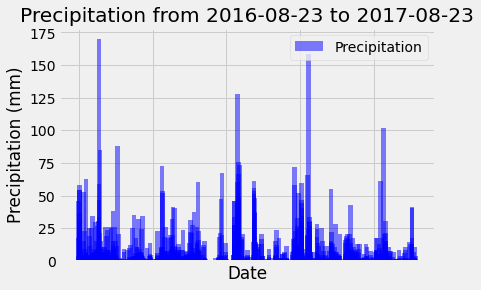

<Figure size 720x720 with 0 Axes>

In [142]:

# Use Pandas Plotting with Matplotlib to plot the data

##Set variables for the plot Dates and Precipitation
x = precip_df['Date']
y = precip_df['Precipitation']


#Plot the plot
plt.bar(x,y,width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')


#Check the tick parameters
plt.tick_params( axis='x', which='both', bottom=True, top=False,labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)


##Plot Labels
plt.title(f"Precipitation from 2016-08-23 to 2017-08-23")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()

plt.figure(figsize=(10,10))
plt.show()



# Exploratory Station Analysis

In [157]:
# Design a query to calculate the total number stations in the dataset

total_stations = session.query(Station).distinct().count()

print(total_stations)

9


In [163]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

sel = [Measurement.station,func.count(Measurement.id)]

# List the stations and the counts in descending order.
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [164]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#query for min, max, av temp -tobs in Measurement table
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

#query into the most active station as seen above which is 'USC00519281', 2772
mostactive_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()

mostactive_station


(12.2, 29.4, 22.03582251082252)

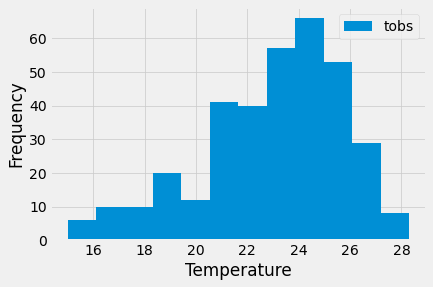

In [181]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= query_date).all()

#put into dataframe
temp_df = pd.DataFrame(query_temp, columns=['Temperature'])

temp_df

#Plot histogram
plt.hist(temp_df['Temperature'], bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')

plt.legend()
plt.show()



# Close session

In [182]:
# Close Session
session.close()